In [7]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
user_info = pd.read_csv("data/user_info.txt", sep="\t", header=None, names=[
    "user_id", "expert_tags", "word_id", "char_id"
])
question_info = pd.read_csv("data/question_info.txt", sep="\t", header=None, names=[
    "question_id", "tag", "word_id", "char_id", "upvotes", "answers", "top_answers"
])

train_info = pd.read_csv("data/invited_info_train.txt", sep="\t", header=None, names=[
    "question_id", "user_id", "answered"
])

safeInt = lambda v: int(v) if v != '' else None
cleanFeature = lambda r: map(safeInt, r.split('/'))

# single time computation
find_max = lambda v: max(cleanFeature(v))
find_min = lambda v: min(cleanFeature(v))

# Computing the parameter ranges to vectorize user parameters
USER_TAG = [0, 142]
# max_expert_tag = user_info['expert_tags'].apply(find_max).max()
# min_expert_tag = user_info['expert_tags'].apply(find_min).min()

USER_WORD_ID = [0, 37809]
# max_word_id = user_info['word_id'].apply(find_max).max()
# min_word_id = user_info['word_id'].apply(find_max).min()

USER_CHAR_ID = [0, 4021]
# max_char_id = user_info['char_id'].apply(find_max).max()
# min_char_id = user_info['char_id'].apply(find_max).max()

QUESTION_TAG = [0, 19]
# max_question_tag = question_info['tag'].max()
# min_question_tag = question_info['tag'].min()

QUESTION_WORD_ID = [0, 13230]
# max_word_id = question_info['word_id'].apply(find_max).max()
# min_word_id = question_info['word_id'].apply(find_max).max()

QUESTION_CHAR_ID = [0, 2958]
# max_char_id = question_info['char_id'].apply(find_max).max()
# min_char_id = question_info['char_id'].apply(find_max).max()

question_info['ease'] = ( question_info['answers'] - question_info['answers'].min()  ) / question_info['answers'].max()
question_info['popularity'] = ( question_info['top_answers'] - question_info['top_answers'].min() ) / question_info['top_answers'].max()
question_info['votability'] = ( question_info['upvotes'] - question_info['upvotes'].min() ) / question_info['upvotes'].max()
question_info['nTag'] = ( question_info['tag'] - question_info['tag'].min() ) / question_info['tag'].max()
question_info['answerability'] = ( question_info['top_answers'] / question_info['answers'] )
question_info['answerability'] =  question_info['answerability'].fillna(0)

# ASKED vs ANSWERED
answered = train_info[ train_info.answered == 1 ].groupby('user_id').count()['answered']
asked = train_info.groupby('user_id').count()['answered'].rename('asked')
user_info = user_info.join(answered, on="user_id", how="left" ).join(asked, on="user_id", how="left" )
user_info['answered'] =  user_info['answered'].fillna(0)
user_info['asked']    =  user_info['asked'].fillna(0)

answered = train_info[ train_info.answered == 1 ].groupby('question_id').count()['answered']
asked = train_info.groupby('question_id').count()['answered'].rename('asked')
question_info = question_info.join(answered, on="question_id", how="left" ).join(asked, on="question_id", how="left")
question_info['answered'] =  question_info['answered'].fillna(0)
question_info['asked']    =  question_info['asked'].fillna(0)

user_info['idx'] = user_info.index
question_info['idx'] = question_info.index

In [11]:
def expand(df):
    row  = [ ]
    col  = [ ]
    data = [ ]
    for i in df.index:
        for e in [x for x in df.ix[i] if x is not None]:
            row.append(i)
            col.append(e)
            data.append(1)  
    return (row, col, data)

def vectorize(ds, column):
    splitFeatures = ds[column].apply(cleanFeature)
    return expand(splitFeatures)

def writeResults(fileName, data):
    f = open("data/" + fileName, "w+")
    for d in data:
        f.write(",".join(map(str, d)))
        f.write("\n")
    f.close()

In [4]:
import libpmf.libpmf as libpmf
from scipy import sparse

def MF(d, column, f1, f2, k=5):
    (row, col, data) = vectorize(d, column)
    V = scipy.sparse.csr_matrix((data, (row, col)))
    model = libpmf.train(V, '-k {0} -l 0.1 -t {0}'.format(k))
    writeResults(f1, model['W'])
    writeResults(f2, model['H'])

MF(user_info, "expert_tags", 'user-expert-latent', 'expert-user-latent', 5)
MF(user_info, "word_id", 'user-word-latent', 'word-user-latent', 10)
MF(user_info, "char_id", 'user-char-latent', 'char-user-latent', 10)
MF(question_info, "word_id", 'question-word-latent', 'word-question-latent', 10)
MF(question_info, "char_id", 'question-char-latent', 'char-question-latent', 10)

libpmf/libpmf.py:60: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if None in [row_idx, col_idx, obs_val, m, n]:


In [5]:
question_word_latent = pd.read_csv("data/question-word-latent", sep=",", header=None, names=[
    "wq1", "wq2", "wq3", "wq4", "wq5", "wq6", "wq7", "wq8", "wq9", "wq10"
])
question_char_latent = pd.read_csv("data/question-char-latent", sep=",", header=None, names=[
    "cq1", "cq2", "cq3", "cq4", "cq5", "cq6", "cq7", "cq8", "cq9", "cq10"
])
question_info = pd.concat([question_info, question_word_latent, question_char_latent], axis=1, join_axes=[question_info.index])

user_word_latent = pd.read_csv("data/user-word-latent", sep=",", header=None, names=[
    "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10"
])
user_char_latent = pd.read_csv("data/user-char-latent", sep=",", header=None, names=[
    "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10"
])
user_expert_latent = pd.read_csv("data/user-expert-latent", sep=",", header=None, names=[
    "t1", "t2", "t3", "t4", "t5"
])
user_info = pd.concat([user_info, user_word_latent, user_char_latent, user_expert_latent], axis=1, join_axes=[user_info.index])

In [6]:
user_info.index = user_info['user_id']
question_info.index = question_info['question_id']
user_info.to_csv("data/user-features", sep=",", columns=[
    "t1", "t2", "t3", "t4", "t5",
    "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10",
    "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10",
])
question_info.to_csv("data/question-features", sep=",", columns=[
    "tag", "upvotes", "answers", "top_answers",
    "nTag", "votability", "ease", "popularity", "answerability",
    "wq1", "wq2", "wq3", "wq4", "wq5", "wq6", "wq7", "wq8", "wq9", "wq10",
    "cq1", "cq2", "cq3", "cq4", "cq5", "cq6", "cq7", "cq8", "cq9", "cq10",
])

Distribution of answerability


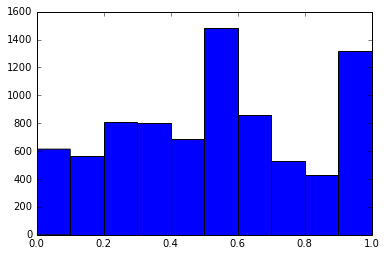

In [8]:
print "Distribution of answerability"
plt.hist(question_info['answerability'], bins=10)
plt.show()

Distribution of tags


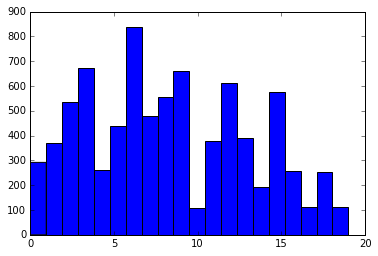

In [12]:
print "Distribution of tags"
plt.hist(question_info['tag'], bins=20)
plt.show()

Corelation between ease and popularity: 74.4624494725%


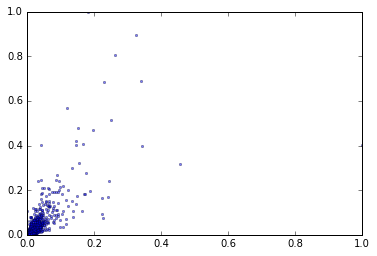

Variation of correlation between ease and popularity WRT answerability


/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


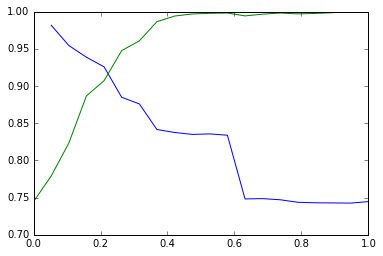

Answerability = 0.2 splits the dataset into 2 parts highly coreelated sets


In [13]:
ease_vs_popularity = np.corrcoef(question_info['ease'], question_info['popularity'])[ 0, 1]
print "Corelation between ease and popularity: {0}%".format(ease_vs_popularity * 100)
plt.plot(question_info['popularity'], question_info['ease'], "o", ms=2.5, alpha=0.5)
plt.show()

print "Variation of correlation between ease and popularity WRT answerability"
k = np.linspace(0, 1, num=20)
subs1 = lambda v: question_info[ question_info.answerability <= v  ]
subs2 = lambda v: question_info[ question_info.answerability > v   ]
ease_vs_popularity_1 = map(lambda v: np.corrcoef(subs1(v)['ease'], subs1(v)['popularity'])[ 0, 1], k)
ease_vs_popularity_2 = map(lambda v: np.corrcoef(subs2(v)['ease'], subs2(v)['popularity'])[ 0, 1], k)

plt.plot(k, ease_vs_popularity_1)
plt.plot(k, ease_vs_popularity_2)
plt.show()

print "Answerability = 0.2 splits the dataset into 2 parts highly coreelated sets"

Ease vs Popularity


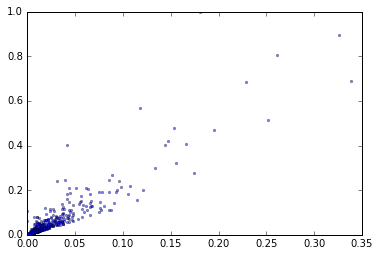

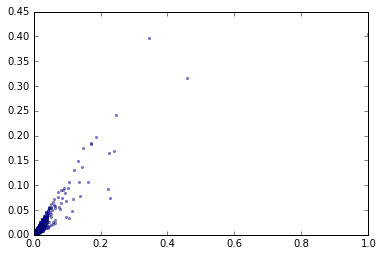

Distribution of tags


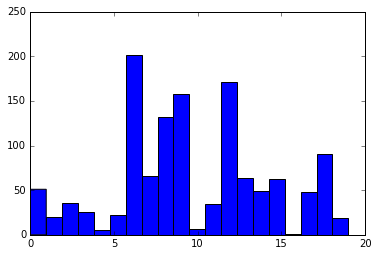

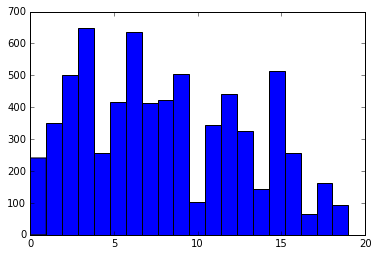

In [21]:
ds1 = subs1(0.2)
ds2 = subs2(0.2)

print "Ease vs Popularity"
plt.plot(ds1['popularity'], ds1['ease'], "o", ms=2.5, alpha=0.5)
plt.show()
plt.plot(ds2['popularity'], ds2['ease'], "o", ms=2.5, alpha=0.5)
plt.show()

print "Distribution of tags"
plt.hist(ds1['tag'], bins=20)
plt.show()
plt.hist(ds2['tag'], bins=20)
plt.show()

In [66]:
def normalForm(d, fileName, column):
    split = d[column].apply(lambda x: x.split('/'))
    f = open(fileName, "w+")
    
    for i in range(len(split)):
        words = split.ix[i]
        for w in words:
            f.write("{0},{1}\n".format(i, w))

    f.close()

print "qWord"
normalForm(question_info, 'data/question-word', "word_id")
print "qChar"
normalForm(question_info, 'data/question-char', "char_id")

print "uWord"
normalForm(user_info, 'data/user-word', "word_id")
print "uChar"
normalForm(user_info, 'data/user-char', "char_id")


qWord
qChar
uWord
uChar


In [77]:
qWord = pd.DataFrame.from_csv("data/question-word", header=None, index_col=None)
qWord.columns=['question_id', 'word_id']
qChar = pd.DataFrame.from_csv("data/question-char", header=None, index_col=None)
qChar.columns=['question_id', 'char_id']
uWord = pd.DataFrame.from_csv("data/user-word", header=None, index_col=None)
uWord.columns=['user_id', 'word_id']
uChar = pd.DataFrame.from_csv("data/user-char", header=None, index_col=None)
uChar.columns=['user_id', 'char_id']

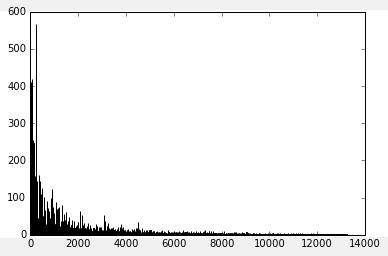

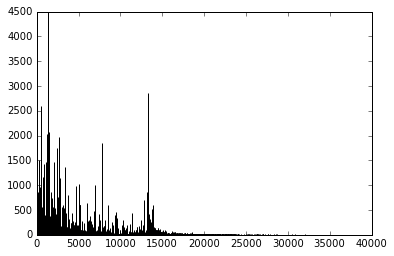

In [84]:

q = qWord.groupby('word_id').count()
u = uWord.groupby('word_id').count()

plt.bar(q['question_id'].index, q['question_id'])
plt.show()

plt.bar(u['user_id'].index, u['user_id'])
plt.show()

#.sort(columns=['question_id'], ascending=False)

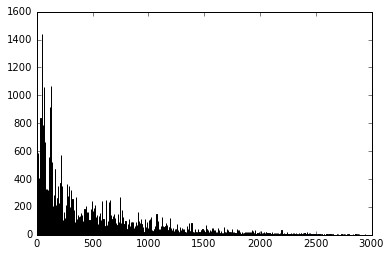

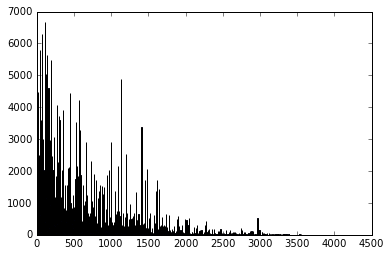

In [85]:
q = qChar.groupby('char_id').count()
u = uChar.groupby('char_id').count()

plt.bar(q['question_id'].index, q['question_id'])
plt.show()

plt.bar(u['user_id'].index, u['user_id'])
plt.show()

In [88]:
normalForm(user_info, 'data/user-tag', "expert_tags")
uTags = pd.DataFrame.from_csv("data/user-tag", header=None, index_col=None)
uTags.columns=['user_id', 'tag_id']

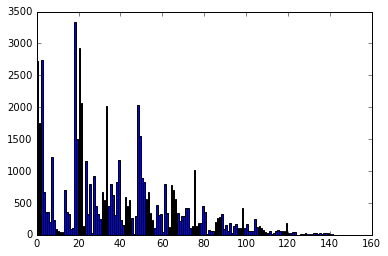

In [89]:
u = uTags.groupby('tag_id').count()
plt.bar(u['user_id'].index, u['user_id'])
plt.show()

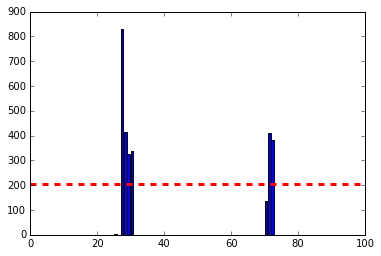

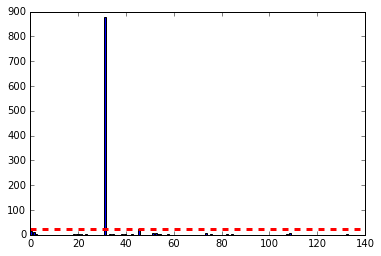

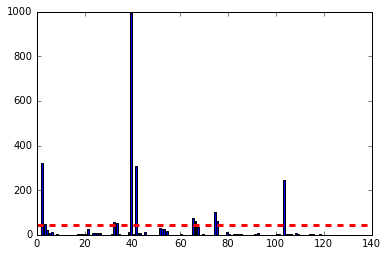

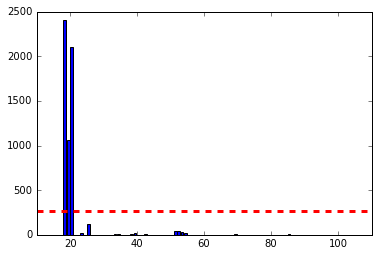

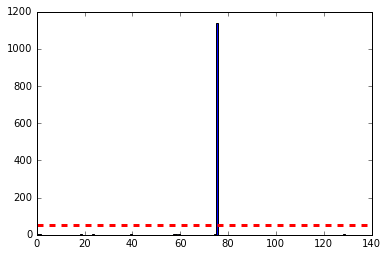

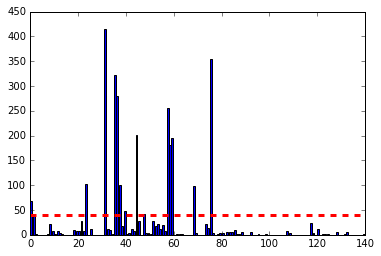

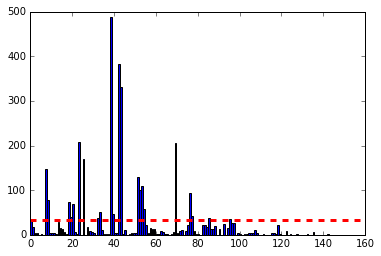

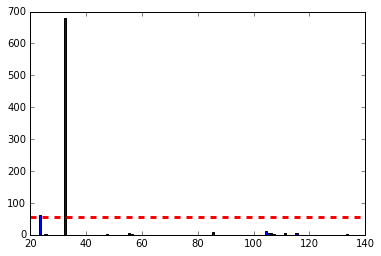

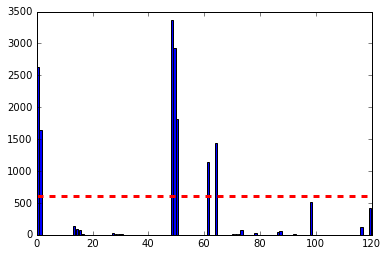

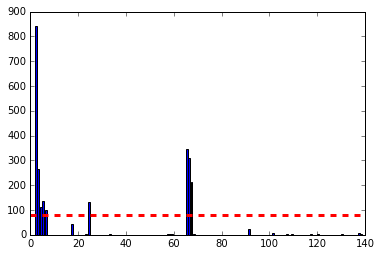

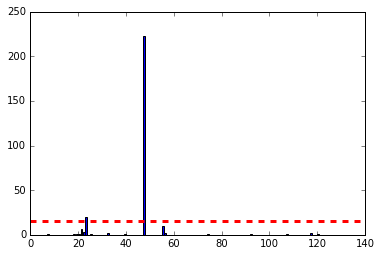

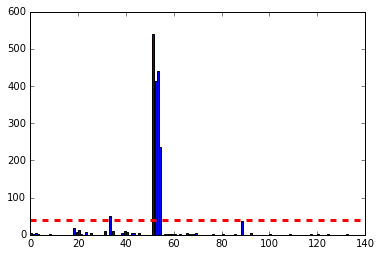

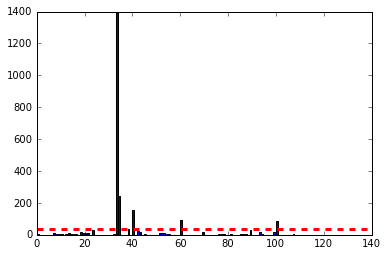

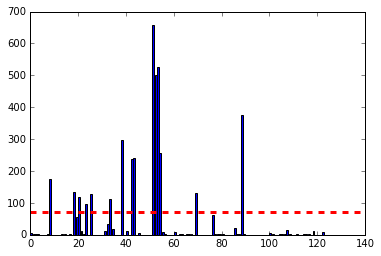

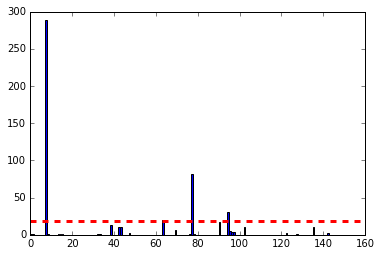

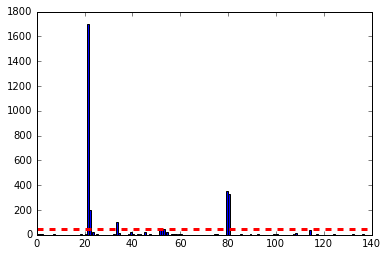

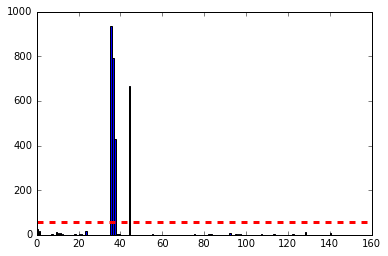

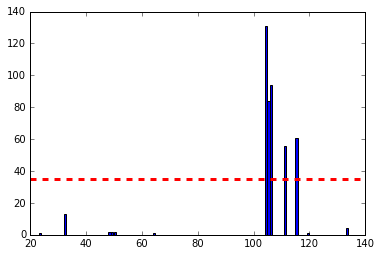

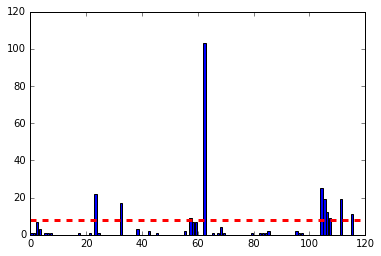

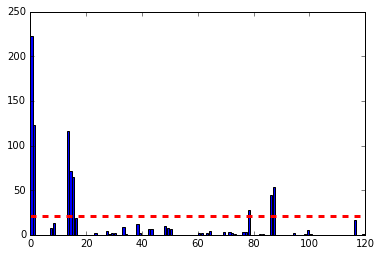

In [135]:
sld = train_info[train_info.answered == 1].merge(user_info[['idx', 'user_id']], left_on='user_id', right_on='user_id', how='inner')

sld = sld.merge(question_info[['idx', 'tag', 'question_id']], left_on='question_id', right_on='question_id', how='inner')

sld = sld.merge(uTags, left_on='idx_x', right_on='user_id', how='inner')


for i in range(20):
    u = sld[sld.tag == i].groupby('tag_id').count()
    plt.bar(u['idx_x'].index, u['idx_x'])
    plt.axhline(u['idx_x'].mean(), color='red', linestyle='dashed', linewidth=3)
    plt.show()

In [144]:
rule = { }
for i in range(20):
    u = sld[sld.tag == i].groupby('tag_id').count()
    rule[i] = u[u.idx_x > u['idx_x'].mean()].index.tolist()

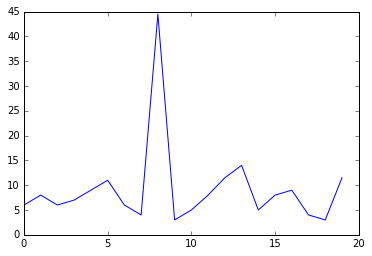

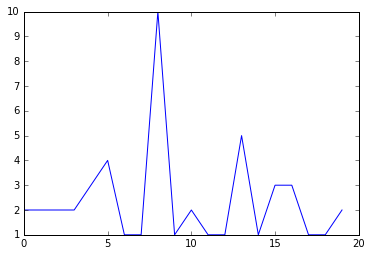

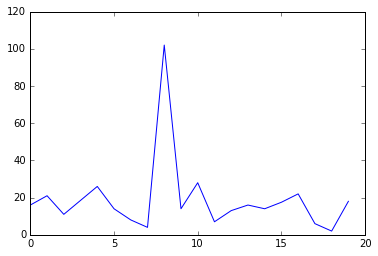

In [155]:
plt.plot(question_info.groupby('tag').median()['answers'])
plt.show()

plt.plot(question_info.groupby('tag').median()['answered'])
plt.show()

plt.plot(question_info.groupby('tag').median()['asked'])
plt.show()



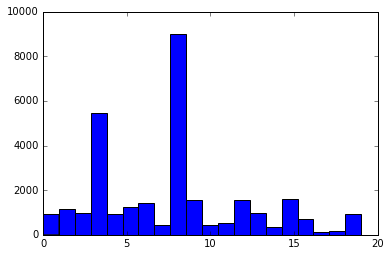

In [132]:
test_info = pd.read_csv("data/test.csv", sep=",", names=[
    "question_id", "user_id", "answered"
])

test_info = test_info.merge(user_info[['idx', 'user_id']], left_on='user_id', right_on='user_id', how='inner')
test_info = test_info.merge(question_info[['idx', 'tag', 'question_id']], left_on='question_id', right_on='question_id', how='inner')

plt.hist(test_info['tag'], bins=20)
plt.show()


In [3]:
# Cold Start
ui = pd.read_csv("data/user-features")

answered = train_info[ train_info.answered == 1 ].groupby('user_id').count()['answered']
asked = train_info.groupby('user_id').count()['answered'].rename('asked')
ui = ui.join(answered, on="user_id", how="left" ).join(asked, on="user_id", how="left" )
ui['answered'] =  ui['answered'].fillna(0)
ui['asked']    =  ui['asked'].fillna(0)

ui['idx'] = ui.index

FEATURES = [
    "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10",
    "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10",
    "t1", "t2", "t3", "t4", "t5",
]

In [24]:
cs = ui[ ui.asked == 0 ]
hs = ui[ ui.asked != 0 ]

K = 0.1

In [26]:
from scipy.spatial import distance

c = cs.ix[18]
hs['sim'] = hs.apply(lambda r: distance.euclidean(c[ FEATURES ], r[ FEATURES ]), axis=1)

/Users/nithinkrishna/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [149]:
from util.eval import generate_ndcg_scores

# results = generate_ndcg_scores("data/validate.csv", "results.csv")
# wrong  = filter(lambda s: s[0] == 0, results)
# q = map(lambda s: s[1], wrong)


# wr_q = question_info[ question_info.question_id.isin(q) ]
# plt.plot(wr_q['answered'], wr_q['asked'], "o", ms=2.5, alpha=0.5)
# plt.show()





,question_id,tag,word_id,char_id,upvotes,answers,top_answers,ease,popularity,votability,nTag,answerability,answered,asked,idx
49,d8a274ec468ed6cfc3cf6ccb29b6ffd3,3,263/21/264/45/265,352/353/33/34/144/218/73/354/355,0,0,0,0.0,0.0,0.0,0.157895,0.0,0.0,15.0,49
52,e0ac50bb307a7c8ac833a83c25aa8b1b,9,277/278/279/280/281/282/283,188/28/365/149/366/98/367/368/369/370/371/372/368,0,0,0,0.0,0.0,0.0,0.473684,0.0,0.0,33.0,52
160,ac0510cef4841f23b80b1d63c53cf92c,14,751/115/312/752/753/754,782/425/68/185/27/400/26/28/783/466/277/428,0,0,0,0.0,0.0,0.0,0.736842,0.0,0.0,14.0,160
185,af97bc59d26ed862db7fc85da056065c,9,849/850/799/380/851/852,573/158/861/104/517/85/686/476/862/170/863/120...,0,0,0,0.0,0.0,0.0,0.473684,0.0,0.0,2.0,185
284,90f018be59efaceb00e0e8c8ef52be5d,17,172/1183/1184/1011/1185/1186/1187/1188,129/263/220/49/167/406/292/1066/98/449/529/106...,0,0,0,0.0,0.0,0.0,0.894737,0.0,0.0,9.0,284
324,6e89eb37f54bc2eb14fbe43b5309d705,6,1335/1336/1337/1338/501/132/954/1339/1340,748/959/1137/1138/32/800/487/494/75/128/587/12...,0,0,0,0.0,0.0,0.0,0.315789,0.0,0.0,15.0,324
395,2db8381f0034c55a7522f361a12a2401,0,1105/1440/1560/1561/1010/1562/256/1563/1564,1/644/131/711/1/162/533/859/320/283/1/42/139/4...,0,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,33.0,395
423,a6ca225a5e935635a329b5f6eddec746,9,1652/1653/1654/1655/1656/406,797/1279/574/145/72/712/173/272/693/694/143/12...,0,0,0,0.0,0.0,0.0,0.473684,0.0,0.0,18.0,423
454,6c5b2a32b83df90c76a911e5c184d4b6,9,1749/489/1456,1054/1314/681/488/183/686,0,0,0,0.0,0.0,0.0,0.473684,0.0,0.0,18.0,454
470,b0ea75566f5bd84817bbd8e0e9a3fd39,12,1797/1798/1799/1800/1801,1335/730/330/109/866/943/203/201/139/128/86,0,0,0,0.0,0.0,0.0,0.631579,0.0,0.0,3.0,470


In [153]:
results = pd.read_csv("results.csv", sep=",")

results_u = results.groupby('question_id').count()['answered']

# print results_u[results_u < 5].index
# results.ix[ , 'answered' ] = 1

invalid = results_u[ results_u < 5 ].index
results.ix[results[results.question_id.isin(invalid)].index, 'answered'] = 1
#results.ix[results[results.question_id.isin(invalid)].index].apply(lambda r:  np.random.random_sample(), axis=1)

# Imputation will help here
# results[results.question_id.isin(question_info[question_info.answers == 0]['question_id']), 'answered'] = 
# results[results.question_id.isin(question_info[question_info.answered == 0]['question_id'])] = 

results[results.question_id.isin(question_info[question_info.answered == 0]['question_id'])].groupby('question_id').count()

# results.to_csv('test-results.csv', sep=',', index=None)

,user_id,answered
question_id,,
000e1e2818667b69584d7c4cb776ae62,2,2
002069042d756f6fa873b2ed9796accd,2,2
002ff794a47f265eb19dfa0db42da103,1,1
0038cebcfd7268447420d3a64b588c3b,1,1
003a41b2367eb7009d1482ae729bb43d,1,1
007950dc6560ccd9651a5568057b1f28,3,3
00ba7cb757b0f22d7ee8c5fc26258678,4,4
00ecb996c927a7de5a3004c85d99a03f,1,1
014c7dc156e02d93218559cc35a791e5,5,5
